<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #F4330C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #F7C8C0; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Pozor</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Připomínám, že 2.5. **neproběhne** cvičení v prezenční formě! Tento notebook slouží pro samostatné seznámení s tématem.

Vaším úkolem je látku projít a **doplnit** buňky podle vyznačených úkolů.
Pro započítání docházky z této hodiny mi pošlete tento notebook s vyplněnými úkoly mailem. V případě nejasností se můžete podívat na materiály [Martina Jirky](https://mjirka.github.io/nme/Cviceni09vyplnene.html) nebo na video [Honzy Vábka](https://youtu.be/po1m34mcjAI?si=Ch3zstxQ1Ymdx0BA).
</p>
</div>
</div>

# Numerická integrace (1D)

V tomto cvičení si ukážeme několik numerických metod pro vyčíslení integrálů funkcí jedné proměnné (1D) na počítači. Ukažeme si také, jak se v určuje **chyba** a jak získat metodu vyššího řádu pomocí *Rombergovy metody*.

Numerické integrování funkcí, také nazývané *kvadratura* (výpočet obsahu plochy), spočívá v nahrazení integrálu konečnou sumou aproximující jeho hodnotu. Konkrétně se zajímáme o vyhodnocení intergálu tvaru:

$$
I = \int_a^{b} f(x) dx.
$$

Tato úloha je úzce spojená s řešením obyčejných diferenciálních rovnic (ODE). Výpočet určitého integrálu je **speciální případ řešení ODE**, tedy přímo ekvivalentní úloze:

$$
\frac{dI}{dx} = f(x),
$$

s počáteční podmínkou $I(a) = 0$, kde hledáme $I(b)$. Metody pro řešení ODE kladou důraz na zavedení *adaptivního kroku* ($h$), kterým lze snadno kontrolovat chybu výpočtu v závislosti na tvaru funkce $f(x)$. V některých případech může být skutečně výhodné úlohu výpočtu integrálu převést na ODE a řešit pomocí těchto metod. Řešením ODE budeme zabývat příští cvičení.

V první části si představíme několik jednoduchých pravidel: *Newton-Cortesovy vzorce*. Přestože byly používány po staletí, v dnešní době se v praxi používají již pokročilejší metody, které poskytují rychlejší *konvergenci* (menší počet vyhodnocení hodnoty funkce pro dosažení dané přesnosti) a zárověň davají **přesný** výsledek pro polynomy vysokého řádu.
Zde si ukážeme jednu z těchto moderních metod: *Gaussovy kvadratury*.
Na záver nahlídneme do problému integrování funkcí více proměnných.

Na přednášce byly ukázány také případy integrálu se singularitami nebo případ integrálu s nekonečnými mezemi. Tyto integrály lze typicky převést na určitý integrál konečného intervalu bez singularit. Proto se těmito případy zde zabývat nebudeme a budeme předpokládat integrál funkcí bez singularit přes konečný interval. O pokročilejších numerických metodách umožňujících přímo integrovat i tyto komplikované integrály se můžete dočíst v literatuře, viz [Numerical Recipes](literatura).

Import knihoven:

In [84]:
import numpy as np
import matplotlib.pyplot as plt

Různé metody budeme testovat na následující funkci:

In [85]:
# definice funkce
def f(x):
    return np.sin(x) * np.exp(np.cos(x))

# integrační inverval
a = 0.1
b = 2.8

Pro ověření porovnáme s přesnou hodnotou, kterou lze snadno v tomto případě spočítat pomocí primitivní funkce $F(x) = -\exp(\cos{(x)})$:

In [86]:
# presna hodnota
def F(x):
    return -np.exp(np.cos(x))

I_pres = F(b) - F(a)
print(I_pres)

2.3149749160962623


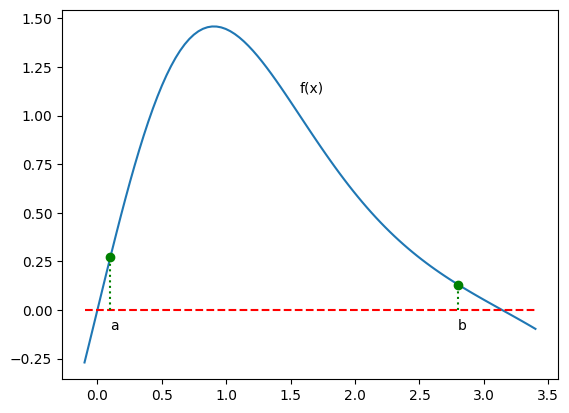

In [87]:
# vykreslení funkce
x_vals = np.linspace(-0.1, 3.4, 100)
plt.plot(x_vals, f(x_vals));
plt.hlines([0], xmin=-0.1, xmax=3.4, colors=['r'], linestyles=['--'])
plt.stem([a, b], [f(a), f(b)], '--g', linefmt=':g', markerfmt='o', basefmt=' ')
plt.text((a+b)/1.85, f((a+b)/2), 'f(x)')
plt.text(a, -0.1, 'a')
plt.text(b, -0.1, 'b');

## Newton-Cortesovy vzorce

Postup numerického výpočtu integrálu je následující. Uvažujeme funkci $f(x)$ a chceme spočítat její integrál na intervalu $(a, b)$. Ten rozdělíme rovnoměrně na $N$ podintervalů definovaných body $x_0, x_1, \dots, x_{N-1}, x_{N}$ velikosti $h$:

$$
x_i = x_0 + i h, \hspace{15pt} i = 0, 1, \dots, N.
$$

Funkci $f$ pak vyhodnocujeme v jednotlivých bodech: $f_i \equiv  f(x_i)$.

![integrace rozdeleni intervalu](../images/integDef.png)

Podle toho, jestli pro výpočet integrálu jsou používány hodnoty funkce v krajních bodech, rozdělujeme pravidla na:
* Uzavřená formule - využívají hodnoty $f(a)$ a $f(b)$
* Otevřená formule - využívají pouze hodnoty uvnitř intervalu

Celé integrační formule se skládají z integračních pravidel pro přibližný výpočet integrálu v malém počtu podintervalů. 
Použítím konkrétního pravidla na všechny podintervaly pak získáme složenou formuli/vzorec na výpočet celého integrálu.
Podrovněji si to ukážeme na jednotlivých pravidlech.

Různé metody poskytují aproximaci integrálu různých řádů přesnosti. Přesto je dobré vždy mít na paměti, že obecně **neplatí**:

vyšší řád $\Rightarrow$ vyšší přesnost

V případě polynomů a téměř hladkých funkcí skutečně vede vyšší řád na přesnější výsledek při stejném počtu vyhodnočení funkce. Ale pokud funkce má například nespojité derivace, můžeme dostat méně přesný výsledek!


Jako první si ukážeme dvě uzavřená pravidla:

![integrace rozdeleni intervalu](../images/NCpravidla2.png)

### Levostranné pravidlo

$$
\int_{x_0}^{x_1} f(x) dx = h f_0 + \mathcal{O}(h^2 f^{\prime})
$$

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #276BE9; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #DCE7FC; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Poznámka</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Chyba aproximace integrálu na jednom podintervalu je druhého řádu v $h$. Zárověn závísí na hodnotě derivace funkce $f$ v neznámém bodě uvnitř intervalu $(x_0, x_1)$. Jelikož tento bod neznáme, musíme velikost chyby určit pomocí jiného odhadu hodnoty integrálu. Stejný případ nastává u ostatních pravidel.
</p>
</div>
</div>

*Složený vzorec* dostaneme aplikací pravidla na všechny podintervaly:
$$
\int_{x_0}^{x_N} f(x) dx = h \left[f_0 + f_1 + \dots + f_{N-1} + f_N\right] + \mathcal{O}\left(\frac{(b - a)^2}{N} f^{\prime}\right),
$$

kde jsme nahradili v odhadu chyby za $N h^2 = \frac{(b - a)^2}{N} = (b-a) h$. Tedy metoda je celkově **prvního řádu** v $N$ a je přesná pro polynomy **nultého řádu** (konstatní funkce).

Zvolíme počet podintervalů:

In [88]:
N = 100  # pocet podintervalu

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Implementujte výpočet integrálu funkce $f$ na intervalu $(a, b)$  pomocí *levostranného pravidla*. 
</p>
</div>
</div>

In [89]:
def integ_levostranne(f, a, b, n):
    I = 0  # hodnota integralu
    x = np.linspace(a, b, n+1)  # krajni body podintervalu x_i
    
    for i in range(n):
        h = x[i+1] - x[i]
        I += h * f(x[i])
    
    return I

I_levo = integ_levostranne(f, a, b, n=N)

print('I_levostranne:', I_levo)
print('I_presny:     ', I_pres)

I_levostranne: 2.3166707678838026
I_presny:      2.3149749160962623


**Odhad chyby integrálu**

Jako u ostatních numerických metod bychom rádi určili chybu, se kterou nám metoda poskytla výsledek pro daný počet vyhodnocení funkce (počet podintervalů $N$).

Jak obecně určit chybu bez znalosti přesného výsledku? K tomu využijeme znalosti řádu metody. Konkrétně pro *levostranné pravidlo* víme, že dostaneme přibližnou hodnotu integrálu ve tvaru (lze odvodit pomocí Taylorova rozvoje, viz přednáška nebo [1]):

$$
I_h = I + a h + b h^2 + ... \equiv  I + \varepsilon(I_h)
$$

Trik spočívá ve využití výsledku stejné metody pro dvakrát větší velikost podintervalů, který je tvaru:

$$
I_{2h} = I + 2 a h + b (2h)^2 + ...
$$

Když oba výsledky odečteme, dostaneme následující odhad chyby pro hodnotu $I_h$:

$$
\varepsilon(I_h) \approx I_{2h} - I_h = a h + 3 b h^2 + ...
$$

Vidíme, že skutečně provádíme pouze **odhad**. Přesnou chybu nedokážeme určit, přesto nám tento odhad stačí. Víme totiž, že odchylka od reálné chyby je až vyššího řádu v $h$ (zde konkrétně $\sim h^2$).

In [90]:
I_h = integ_levostranne(f, a, b, N)
I_2h = integ_levostranne(f, a, b, N//2)

chyba_levo = np.abs(I_2h - I_h)

print('Odhad chyby: ', chyba_levo)
print('Realná chyba:', np.abs(I_pres - I_h))

Odhad chyby:  0.0013221091504242999
Realná chyba: 0.0016958517875402812


### Lichoběžníkové pravidlo

$$
\int_{x_0}^{x_1} f(x) dx = h \left[\frac{1}{2}f_0 + \frac{1}{2}f_1\right] + \mathcal{O}(h^3 f^{\prime \prime})
$$

Složený vzorec opět dostaneme aplikací pravidla na všechny podintervaly:
$$
\int_{x_0}^{x_N} f(x) dx = h \left[\frac{1}{2}f_0 + f_1 + \dots + f_{N-1} + \frac{1}{2}f_N\right] + \mathcal{O}\left(\frac{(b - a)^3}{N^2} f^{\prime \prime}\right).
$$

Vidíme, že tato metoda je celkově **druhého řádu** v $N$ a je přesná pro polynomy až **prvního řádu**.

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Implementujte výpočet integrálu funkce $f$ na intervalu $(a, b)$ pomocí *lichoběžníkového pravidla*. 
</p>
</div>
</div>

In [91]:
def integ_lichobeznik(f, a, b, n):
    I = 0  # hodnota integralu
    x = np.linspace(a, b, n+1)  # krajni body podintervalu x_i
    
    ## DOPLŇTE ##    
    for i in range(n):
        h = x[i+1] - x[i]
        I += h * (1/2 * f(x[i]) + 1/2 * f(x[i+1]))
    
    return I
    
I_lich = integ_lichobeznik(f, a, b, n=N)

print('I_lichobeznik:', I_lich)
print('I_presny:     ', I_pres)

I_lichobeznik: 2.314788087801567
I_presny:      2.3149749160962623


**Odhad chyby integrálu**

Opět chceme určit chybu integrálu. Tentokrát je rozvoj chyby pro *lichoběžníkové pravidlo* následující (lze odvodit pomocí Taylorova rozvoje, viz přednáška nebo [1]):

$$
\begin{align}
    I_h &= I + a h^2 + b h^4 + ... \equiv  I + \varepsilon(I_h) \\
    I_{2h} &= I + a (2h)^2 + b (2h)^4 + ...
\end{align}
$$

Pro odhad chyby tedy dostáváme:

$$
\varepsilon(I_h) \approx \frac{I_{2h} - I_h}{3} = a h^2 + 5 b h^4 + ...
$$

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #276BE9; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #DCE7FC; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Poznámka</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Všimněte si, že rozvoj chyby zde obsahuje pouze sudé mocniny $h$! To znamená, že odhad chyby je pro tuto metodu velmi přesný. Navíc této vlastnosti lze vhodně využít ke konstrukci metod vyšších řádů, jak uvídíme v sekci *Rombergova metoda*.
</p>
</div>
</div>

In [92]:
I_h = integ_lichobeznik(f, a, b, N)
I_2h = integ_lichobeznik(f, a, b, N//2)  # dvojnasobna velikost podintervalu h

chyba_lich = np.abs(I_2h - I_h) / 3

print('Odhad chyby: ', chyba_lich)
print('Realná chyba:', np.abs(I_pres - I_lich))

Odhad chyby:  0.0001868569772705738
Realná chyba: 0.00018682829469529594


### Simpsonovo pravidlo

$$
\int_{x_0}^{x_2} f(x) dx = h \left[\frac{1}{3}f_0 + \frac{4}{3}f_1 + \frac{1}{3}f_2\right] + \mathcal{O}(h^5 f^{(4)})
$$

Složený vzorec opět dostaneme aplikací pravidla na všechny podintervaly (zde implicitně předpokládáme, že $N$ je sudé):

$$
\int_{x_0}^{x_N} f(x) dx = h \left[\frac{1}{3}f_0 + \frac{4}{3}f_1 + \frac{2}{3}f_2 + \frac{4}{3}f_3 + \dots + \frac{2}{3}f_{N-2} + \frac{4}{3}f_{N-1} + \frac{1}{3}f_N\right] + \mathcal{O}\left(\frac{(b - a)^5}{N^4} f^{(4)}\right).
$$

Tato tříbodová metoda je díky jisté symetrii dokonce **čtvrtého řádu** v $N$ a je přesná pro polynomy až **třetího řádu**.

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Implementujte výpočet integrálu funkce $f$ na intervalu $(a, b)$ pomocí *Simpsonova pravidla*. 
</p>
</div>
</div>

In [93]:
def integ_Simpson(f, a, b, n):
    I = 0  # hodnota integralu
    n += n % 2  # chceme n sude !
    x = np.linspace(a, b, n+1)  # krajni body podintervalu x_i
    
    ## DOPLŇTE ##
    for i in range(0, n, 2):
        h = x[i+1] - x[i]
        I += h * (1/3 * f(x[i]) + 4/3 * f(x[i+1]) + 1/3 * f(x[i+2]))
    
    return I
    
I_simp = integ_Simpson(f, a, b, n=N)

print('I_Simpson:', I_simp)
print('I_presny: ', I_pres)

I_Simpson: 2.3149749447788404
I_presny:  2.3149749160962623


**Odhad chyby integrálu**

Opět chceme určit chybu integrálu. Tentokrát je rozvoj chyby pro *Simpsonovo pravidlo* následující:

$$
\begin{align}
    I_h &= I + a h^4 + b h^5 + ... \equiv  I + \varepsilon(I_h) \\
    I_{2h} &= I + a (2h)^4 + b (2h)^5 + ...
\end{align}
$$

Pro odhad chyby tedy dostáváme:

$$
\varepsilon(I_h) \approx \frac{I_{2h} - I_h}{15} = a h^4 + \frac{31}{15} b h^5 + ...
$$

In [94]:
I_h = integ_Simpson(f, a, b, N)
I_2h = integ_Simpson(f, a, b, N//2)

chyba_simp = np.abs(I_2h - I_h) / 15

print('Odhad chyby: ', chyba_simp)
print('Realná chyba:', np.abs(I_pres - I_simp))

Odhad chyby:  2.8747315639066073e-08
Realná chyba: 2.868257809041097e-08


### Obdélníkové pravidlo (midpoint rule)

![integrace rozdeleni intervalu](../images/NCpravidla3.png)

Jedním z otevřených pravidel je *Obdélníkové pravidlo*. Pravidlo může být výhodné využít v případech, kdy je obtížné nebo nemožné vyhodnotit hodnotu funkce v krajích bodech. Otevřená pravidla přesto nejsou dnes tolik zajímavá kvůli existenci pokročilejších metod *Gaussových kvadratur*. Přesto si zde jedno pro ukázku předvedeme:

$$
\int_{x_0}^{x_1} f(x) dx = h f_{1/2} + \mathcal{O}(h^3 f^{\prime \prime})
$$

Složený vzorec dostaneme aplikací pravidla na všechny podintervaly:
$$
\int_{x_0}^{x_N} f(x) dx = h \left[f_{1/2} + f_{3/2} + \dots + f_{N-3/2} + f_{N - 1/2}\right] + \mathcal{O}\left(\frac{(b - a)^3}{N^2} f^{\prime}\right),
$$

Tedy metoda je celkově **druhého řádu** v $N$ a je přesná pro polynomy **prvního řádu**.

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Implementujte výpočet integrálu funkce $f$ na intervalu $(a, b)$ pomocí *obdélníkového pravidla*. 
</p>
</div>
</div>

In [95]:
def integ_obdelnik(f, a, b, n):
    I = 0  # hodnota integralu
    x = np.linspace(a, b, n+1)  # krajni body podintervalu x_i
    
    ## DOPLŇTE ##
    for i in range(n):
        h = x[i+1] - x[i]
        I += h * f((x[i] + x[i+1])/2)
    
    return I
    
I_obdk = integ_obdelnik(f, a, b, n=N)

print('I_obdelnik:', I_obdk)
print('I_presny:  ', I_pres)

I_obdelnik: 2.3150683329311827
I_presny:   2.3149749160962623


**Odhad chyby integrálu**

Opět chceme určit chybu integrálu. Tentokrát je rozvoj chyby pro *obdélníhové pravidlo* následující:

$$
\begin{align}
    I_h &= I + a h^2 + b h^3 + ... \equiv  I + \varepsilon(I_h) \\
    I_{2h} &= I + a (2h)^2 + b (2h)^3 + ...
\end{align}
$$

Pro odhad chyby tedy dostáváme:

$$
\varepsilon(I_h) \approx \frac{I_{2h} - I_h}{3} = a h^2 + \frac{7}{3} b h^3 + ...
$$

In [96]:
I_h = integ_obdelnik(f, a, b, N)
I_2h = integ_obdelnik(f, a, b, N//2)

chyba_obdk = np.abs(I_2h - I_h) / 3
print('Odhad chyby: ', chyba_obdk)
print('Realná chyba:', np.abs(I_pres - I_obdk))

Odhad chyby:  9.344193406590762e-05
Realná chyba: 9.341683492047892e-05


### Rombergova metoda

Při odhadu chyb předchozích metod jsme viděli, že dokážeme přesně určit první člen v rozvoji chyby.
Zajímavá myšlenka, která vede k *Rombergově metodě*, je využít hodnoty odhadu chyby pro zpřesnění vypočtené hodnoty integrálu. Ukážeme si to na *lichoběžníkové metodě*. Matematicky můžeme napsat:

$$
\begin{align}
    I_h &= I + a h^2 + b h^4 + ... \equiv  I + \varepsilon(I_h) \\
    I_{2h} &= I + a (2h)^2 + b (2h)^4 + ...
\end{align}
$$

A pro odhad chyby jsme měli:

$$
\varepsilon(I_h) \approx \frac{I_{2h} - I_h}{3} = a h^2 + 5 b h^4 + ...
$$

Když odečneme chybu $\varepsilon(I_h)$ od hodnoty integrálu:

$$
I_h^{new} = I_h - \varepsilon(I_h) = \frac{4}{3} I_{h} -\frac{1}{3} I_{2h} = I - 4 b h^4 + ...
$$

Dostáváme přesnější odhad hodnoty integralu a celkově metodu **čtvrtého řádu**, podobně jako v případě Simpsonovy metody. Ve skutečnosti dostáváme přesně Simpsonovu metodu (při rozepsáni vyjde stejná rozšířená formule).

Obecně *Rombergova metoda* spočívá v kombinaci výsledků metody pro několik různých hodnot $N$ (nebo $h$). Tím získáme přesnější výsledek a metodu vyššího řádu. *Lichoběžníková metoda* se zde obzvlášť hodí, jelikož rozvoj její chyby obsahuje pouze sudé mocniny a tedy dostáváme metodu o **dva**  řády vyšší!

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Pomocí předchozího vztahu aplikujte Rombergovu metodu s využitím právě *lichoběžníkového pravidla*. Stačí použít kombinaci dvou hodnot integrálu pro $h$ a $2h$. Zárověň určete chybu této nové metody. K tomu je opět potřeba spočítat hodnotu integrálu pro s jinou velikostí kroku $I_{2h}^{new}$.
</p>
</div>
</div>

In [97]:
def integ_lichob_Romberg2(f, a, b, n):
    ## DOPLŇTE ##
    I_h = integ_lichobeznik(f, a, b, n)
    I_2h = integ_lichobeznik(f, a, b, n//2)  # dvojnasobna velikost podintervalu h
    
    I_new = 4/3 * I_h - 1/3 * I_2h
    return I_new

I_lich_romb = integ_lichob_Romberg2(f, a, b, n=N)

print('I_lich_romb:', I_lich_romb)
print('I_Simpson:  ', I_simp)
print('I_presny:   ', I_pres)

I_lich_romb: 2.3149749447788377
I_Simpson:   2.3149749447788404
I_presny:    2.3149749160962623


**Odhad chyby**

Zde je odhad stejný jako u Simpsonovy metody, jelikož jsou obě metody identické. Vidíme, že dostáváme téměř stejnou hodnotu integrálu jako u Simpsonovy metody (výsledek se liší v řádu $10^{15}$ kvůli jinému pořadí operací a tedy díky zaokhrouhlovacím chybám).

In [98]:
I_h = integ_lichob_Romberg2(f, a, b, N)
I_2h = integ_lichob_Romberg2(f, a, b, N//2)

chyba_romb = np.abs(I_2h - I_h) / 15
print('Odhad chyby: ', chyba_romb)
print('Realná chyba:', np.abs(I_pres - I_lich_romb))

Odhad chyby:  2.8747315639066073e-08
Realná chyba: 2.868257542587571e-08


### Srovnání metod - konvergence

V této části srovnáme, s jakou přesností nám jednotlivé metody dávají výsledný integrál.

Definice nespojité funkce pro ověření konvergence pro nehladké funkce:

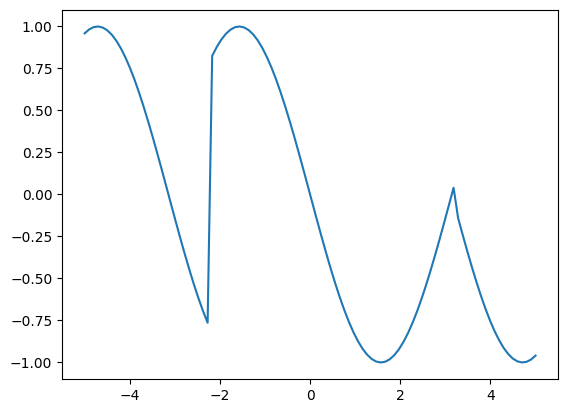

In [99]:
def g(x):
    return np.sin(x) * np.sign(x**2 - 1*x - 7)

x2 = np.linspace(-5, 5, 100)
plt.plot(x2, g(x2));

Definice polynomu stupně `npoly - 1` pro ověření absolutní přesnosti metod:

In [100]:
npoly = 3  # stupen polynomu + 1
fpoly = np.poly1d(np.arange(1, npoly+1))
fpoly

poly1d([1, 2, 3])

In [101]:
M = 12
Nstart = 4

integs = [integ_levostranne, integ_lichobeznik, integ_Simpson, integ_obdelnik, integ_lichob_Romberg2]
chybaCoef = [1, 3, 15, 3, 15]
nI = len(integs)

# prepnuti mezi ruznymi funkcemi
nespojitaFunkce = 1  # ZKUSIT "= 1"
if nespojitaFunkce:
    fun = g
    a = -5
    b = 5
else:
    fun = fpoly  # ZKUSIT "= fpoly"
    a = 0.1
    b = 2.8

# pole pro ulozeni prubezneho vysledku a chyby
errs = np.zeros([nI, M])
Ivals = np.zeros([nI, M])
Ns = np.zeros([nI, M])

for i in range(nI):
    integ = integs[i]
    for j in range(M):
        n = Nstart * 2**j  # zdvojnasobeni poctu podintervalu
        
        # vypocet integralu a chyby
        I_h = integ(fun, a, b, n)
        I_2h = integ(fun, a, b, n//2)
        chyba = np.abs(I_2h - I_h) / chybaCoef[i]
        
        Ns[i][j] = 2*n
        Ivals[i][j] = I_h
        errs[i][j] = chyba

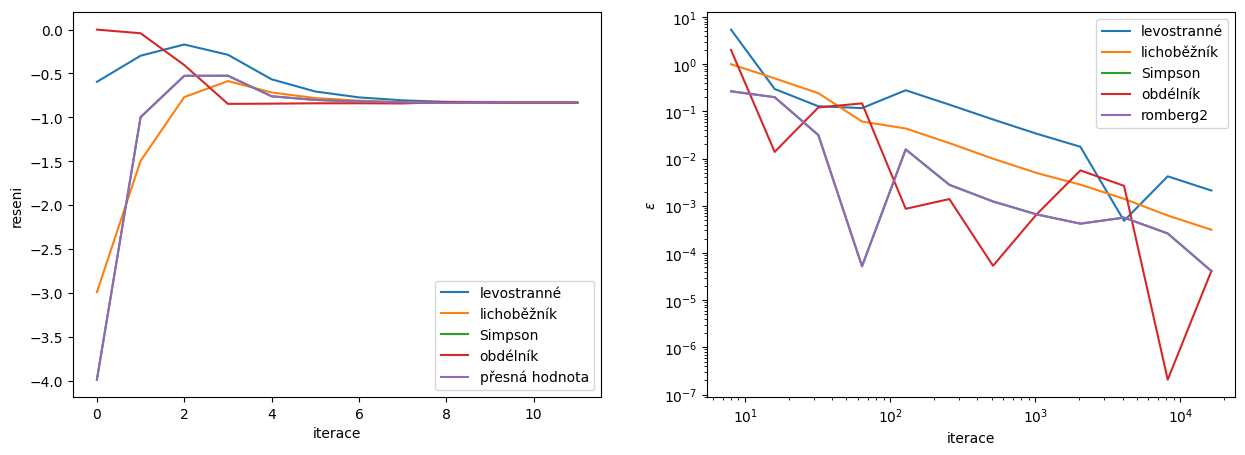

In [102]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

# zobrazime vyvoj reseni v zavislosti na iteracich
ax[0].plot(Ivals.T)
if not nespojitaFunkce:
    ax[0].hlines([I_pres], xmin=0, xmax=M, colors=['k'], linestyles=[':'])
ax[0].set_ylabel('reseni')
ax[0].set_xlabel('iterace')
ax[0].legend(['levostranné', 'lichoběžník', 'Simpson', 'obdélník', 'přesná hodnota', 'romberg2'])

# zobrazime vyvoj chyby v zavislosti na iteracich
ax[1].plot(Ns.T, errs.T)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$\epsilon$')
ax[1].set_xlabel('iterace')
ax[1].legend(['levostranné', 'lichoběžník', 'Simpson', 'obdélník', 'romberg2']);

Na předchozích grafech vidíme srovnání rychlostí konvergence pro jednotlivé představené metody integrace. Skutečně *levostranné pravidlo* vede na metodu prvního řádu, *lichoběžníkové* a *obdélníkové* pravidlo vedou na metodu druhého řádu a nakonec *Simpsonovo pravidlo* nám dává metodu až **čtvrtého řádu**.

Zdálo by se, že bychom chtěli vždy použít Simpsonovu metodu, jelikož nám poskytne větší přesnost s menšími výpočetními nároky. Ale je potřeba si opět uvědomit, že větší přesnost při větším řádu metody platí jen pro polynomy nebo skoro hladké funkce!

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Vyzkoušejte předchozí analýzu na nespojitou funkci $g(x)$. Stačí v předminulé buňce nastavit `nespojitaFunkce = 1` a znovu vykreslit grafy. Jak se změnily konvergence jednotlivých metod? Je stále Simpsonova metoda nejlepší?
</p>
</div>
</div>

// DOPLŇTE ODPOVĚĎ //

Z pravého grafu pozorujeme rozdíl v chování Simpsonovy metody (kopírující Rombergovu metodu). Všechny metody jsou v průméru stejného řádu jako metoda *Levostranného pravidla*, tedy **prvního řádu**! To je způsobeno nespojitostí integrované funkce. Pro takové funkce se chyba metod vyššího řádu vzroste zdůvodu závislosti chyby na derivaci vysokého řádu integrované funkce. Hodnota této derivace roste rapidně s menším krokem, což nakonec vede ve všech prezentovaných případech na **první řád** konvergence. Simpsonova metoda dává v průměru podobně dobrý výsledek jako obdélníková metoda, nižší než zbylé metody.

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Jak bylo popsáno, představené metody jsou přesné pro polynomy do určitého stupně. Ověřte tuto skutečnost opět pomocí dříve zadefinovaného polynomu `fpoly` stupně `npoly`. Stačí nastavit `fun = fpoly` v buňce počítající konvergence metod. Co pozorujete pro polynom `fpoly` stupně 1, 2, 3, 4, 5, 6? Uvědomte si, že chyba $10^{-15} - 10^{-16}$ odpovídá maximální strojové přesnosti.
</p>
</div>
</div>

// DOPLŇTE ODPOVĚĎ //

Pro polynomy nižších stupňů pozorujeme, že metody dostatečného řádu (o jedna vyššího než je stupeň polynomu) dávají přesný výsledek (v řádu strojové přesnosti) už při velkém kroku $h$. Ověřili jsme tedy jednu ze zádladních vlastností těchto metod, vycházející z jejich konstrukce.

## Gaussovy kvadratury

Na přednášce jste viděli teorii týkající se Gaussových kvadratur. Tyto metody jsou v praxi běžně používané, díky tomu, že jsou přesné pro polynomy do stupně až $2N - 1$. Přesto si je zde nepředstavíme, jelikož by bylo časové náročné si je podrobně projít a analyzovat jejich vlastnosti. Na ukázku implementace se můžete podívat například [zde](https://mjirka.github.io/nme/Cviceni09vyplnene.html#).

Tato metoda je pro Python implementována v knihovně SciPy funkcí [`scipy.integrate.quad()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html). Tato funkce počítá hodnotu integrálu se strojovou přesností.

In [103]:
from scipy import integrate

I_gauss, chyba_gauss = integrate.quad(f, a, b)

print('I_gaussKvad:', I_gauss, '| chyba:', chyba_gauss)
print('I_presny:   ', I_pres)

I_gaussKvad: 0.0 | chyba: 7.079853266994228e-14
I_presny:    2.3149749160962623


## Integrace funkcí více proměnných (nD)

V této části se budeme zabývat úlohou integrování funkcí více proměnných. Pro takové funkce lze použít předchozí metody, akorát rozšířené na integrování na nD mřížce. Je potřeba si ale uvědomit, že počet potřebných vyhodnocení funkční hodnoty roste exponenciálně s dimenzí! Například, pokud pro vyhodnocení integrálu je potřeba v každém "směru" (dimenzi) $100$ bodů, musíme funkce v $D = 5$ (funkce pěti proměnných) prostoru vyhodnotit celkem v $100^5 = 10^{10}$ bodech! To již pro jisté funkce nemusí být upočitatelné na běžném počítači..

Funkce více proměnných jsou typicky lokalizované v malé oblasti nD prostoru (všude jinde je funkčí hodnota téměř nulová). Příkladem může být funkce gaussovkého tvaru. Proto se může vyplatit chytře vzorkovat nD prostor. Takové metody jsou založené na statistické teorii a vychází z jednodušších metod, které si zde představíme. Tyto metody využívají náhody, proto nesou název Metody Monte Carlo. Pod tímto označením se neskrývají pouze metody na integrování ale široká škála metod využívající náhodu.

### Metoda Monte Carlo (1D)

Metoda Monte Carlo je založená na statistickém vzorkování funkce. Ukážeme si dva jednoduché způsoby, jak lze vzorkování provést. Tyto metody lze dále vylepšit několika způsoby pro efektivnější vzorkování. Více se dozvíte v předmětu 18MMC.

Výhoda této metody je velmi jednoduchá implementace jak v 1D tak pro nD funce. My si metodu ukážeme opět na naší 1D funkci, rozšíření do nD je již jednoduché.

**První způsob** spočívá v následujících krocích:
0. zvolíme si počet pokusů $N$
1. najdeme $K$ takové, že $K > f(x), \forall  x \in (a, b)$ (zde navíc předpokládáme, že je funkce kladná na celém intervalu - jinak je možné přičíst konstantu, tak aby byla..)
2. vygenerujeme náhodný bod $x_r \in (a, b)$
3. vygenerujeme náhodnou hodnotu $y_r \in (0, K)$
4. vzorek přijmeme, pokud $f(x_r) > y_r$
5. opakujeme body 2.-4. dokud neprovedeme $N$ pokusů
6. pak výsledný integrál odhadneme: $I \approx K (b - a) \frac{M}{N}$, kde $M$ je počet přijatých vzorků

Tato metoda odpovídá statistickému výpoctu obsahu plochy útvaru, definovaném funkcí $f$.

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #276BE9; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #DCE7FC; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Poznámka</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Na volbě $K$ závisí, jak efektivně je funkce $f$ vzorkováná. Pokud zvolíme příliš velké $K$, skoro žádný vzorek nepřijmeme. Ideální je maximum funkce $f$ na intervalu $(a, b)$, které ovšem může být v praxi obtížné určit a zárověň naše snaha je funkci vyhodnotit v co nejméně bodech v nD prostoru.
</p>
</div>
</div>

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Implementujte *první verzi* metody Monte Carlo pro výpočet integrálu funkce $f$. Odhadněte chybu metody.
</p>
</div>
</div>


In [104]:
np.random.rand() * (b - a) + a

-4.537138043658784

In [105]:
a = 0.1
b = 2.8

In [106]:
N = 10000
M = 0

K = 1.5  # zde odhadujeme ze znalosti, jak funkce vypada

for i in range(N):
    xr = np.random.rand() * (b - a) + a  # nahodne cislo z (a,b)
    yr = np.random.rand() * K  # nahodne cislo z (0,K)
    if f(xr) >= yr:
        M += 1
    
I_mmc1 = (b - a) * K * M / N

print('I_monteCarlo1:', I_mmc1)
print('I_presny:     ', I_pres)

I_monteCarlo1: 2.290275
I_presny:      2.3149749160962623


Nevýhoda metody Monte Carlo je rychlost konvergence. Je možné ukázat, že chyba je tvaru:

$$
\varepsilon \approx V \sqrt{\frac{\sigma_N}{M}} = V \sqrt{\frac{\langle f^2 \rangle - \langle f \rangle ^2}{M}} \sim \frac{1}{\sqrt{M}},
$$

kde $\sigma_N$ je variance, $V$ velikost oblasti a $N$ počet vzorků. Chyba tedy klesá pouze s odmocninou počtu vzorků! Je tedy jasné, že pro funkce málo proměnných je naprosto neužitečná, jelikož máme k dispozici metody, které konvergují výrazně rychleji. Ale při $D \geq 8$ už začíná mít tato metoda (ve vylepšené formě) význam a velká výhoda je pak jednoduchost implementace.

Pro první metodu použijeme pouze $\varepsilon \sim \frac{1}{\sqrt{M}}$. Přesnější vztah s variací lze použít u druhé verze.

In [107]:
# zde odhadneme pouze pomoci 1/sqrt(M)

chyba_mmc1 = (b - a) / np.sqrt(M)
print('Odhad chyby: ', chyba_mmc1)
print('Realná chyba:', np.abs(I_pres - I_mmc1))

Odhad chyby:  0.03590438230125973
Realná chyba: 0.02469991609626243


**Druhá verze** metody Monte Carlo používá nahrazení integrálu pomocí konečného součtu funkčních hodnot v náhodně vygenerovaných bodech $x_i$:

$$
\int_V f(x) \approx V \frac{1}{N} \sum_{i=1}^{N} f(x_i) = V \langle f \rangle
$$

Velká výhoda této verze je, že nemusíme určovat konstantu $K$ a také funkce může být rovnou záporná i kladná na intervalu $(a, b)$. Také lze přesněji odhadnout chybu pomocí variace, jelikož počítáme s funkčními hodnotami:

$$
\varepsilon \approx V \sqrt{\frac{\langle f^2 \rangle - \langle f \rangle ^2}{M}},
$$

kde $\langle f \rangle = \frac{1}{N} \sum_{i=1}^{N} f(x_i)$ a $\langle f^2 \rangle = \frac{1}{N} \sum_{i=1}^{N} f^2(x_i)$.

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Implementujte *druhou verzi* metody Monte Carlo pro výpočet integrálu funkce $f$. Odhadněte chybu metody.
</p>
</div>
</div>

In [108]:
M = 10000

f_sum = 0  # prubezny soucet funkcnich hodnot f(xi)
f2_sum = 0 # prubezny soucet druhe mocniny funkcnich hodnot f(xi)**2 - pro vypocet chyby

for i in range(M):
    ## DOPLŇTE ##
    xr = np.random.rand() * (b - a) + a  # nahodne cislo z (a,b)
    f_sum += f(xr)
    f2_sum += f(xr)**2
    
I_mmc2 = (b - a) / M * f_sum

print('I_monteCarlo2:', I_mmc2)
print('I_presny:     ', I_pres)

I_monteCarlo2: 2.321535281189562
I_presny:      2.3149749160962623


In [109]:
# zde odhadneme pouze pomoci var/sqrt(M)

chyba_mmc2 = (b - a) * np.sqrt((f2_sum / M - (f_sum / M)**2) / M)
print('Odhad chyby: ', chyba_mmc2)
print('Realná chyba:', np.abs(I_pres - I_mmc2))

Odhad chyby:  0.011752135864886262
Realná chyba: 0.006560365093299936


Vidíme, že i pro větší počty vzorků máme výsledek přesně jen na malý počet číslic. Implementace pro funkce mnoha proměnných by byla analogická, akorát by bylo potřeba generovat více náhodných čísel pro jednotlivé proměnné.

## Zápočtová úloha - Metoda Monte Carlo (nD)

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol - zápočet 8</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

[ZDE](ukol8)
</p>
</div>
</div>